#### Gaussian process regressor with Matern kernel

In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error, r2_score

# plot parameters
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'large',
    'font.size': 10,
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [24]:
path = '/nfs/a336/earlacoa/paper_aia_china/emulator/'

with open(path + 'dict_train.pickle', 'rb') as ds:
    dict_train = pickle.load(ds)
    
with open(path + 'dict_test.pickle', 'rb') as ds:
    dict_test = pickle.load(ds)

In [25]:
df_train = pd.concat(dict_train, ignore_index=True)
df_test = pd.concat(dict_test, ignore_index=True)

In [26]:
df_train

,lat,lon,PM2_5_DRY,o3,AOD550_sfc,asoaX_2p5,bc_2p5,bsoaX_2p5,nh4_2p5,no3_2p5,oc_2p5,oin_2p5,so4_2p5
0,18.25,109.00,18.925155,53.408409,0.279784,0.193393,0.311210,0.029954,0.655250,4.005385,1.094371,5.208624,1.086682
1,18.25,109.25,18.823809,52.980226,0.275409,0.187394,0.305428,0.028074,0.652673,4.069840,1.059748,5.132386,1.054859
2,18.25,109.50,18.828539,52.719304,0.281442,0.182538,0.304053,0.026417,0.644458,4.113190,1.052629,5.081025,1.027360
3,18.50,108.75,19.212973,50.457721,0.286369,0.188372,0.336242,0.032517,0.703820,3.968032,1.206351,5.539987,1.138709
4,18.50,109.00,18.888069,48.074796,0.271764,0.178748,0.335047,0.030330,0.706717,3.963471,1.187698,5.511708,1.106557
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763895,53.25,122.75,4.142248,38.627859,0.087037,0.018335,0.070363,0.018335,0.348197,0.586286,0.099392,1.370916,0.510006
763896,53.25,123.00,4.172716,38.581789,0.087134,0.018299,0.071970,0.018299,0.348956,0.589522,0.103505,1.375964,0.509347
763897,53.25,123.25,4.238289,38.517382,0.087279,0.018325,0.076279,0.018325,0.350512,0.595519,0.112202,1.400196,0.508916
763898,53.25,123.50,4.220053,38.485862,0.087397,0.018474,0.074712,0.018474,0.352051,0.601684,0.112031,1.380757,0.507909


In [27]:
df_test

,lat,lon,PM2_5_DRY,o3,AOD550_sfc,asoaX_2p5,bc_2p5,bsoaX_2p5,nh4_2p5,no3_2p5,oc_2p5,oin_2p5,so4_2p5
0,18.25,109.00,24.377515,55.772358,0.333984,0.192984,0.755014,0.026087,0.809453,4.899959,2.094016,6.951931,1.101783
1,18.25,109.25,24.259407,55.080988,0.328923,0.188026,0.748586,0.024597,0.810817,4.985641,2.056657,6.871297,1.070137
2,18.25,109.50,24.253184,54.656002,0.334498,0.183899,0.743235,0.023258,0.810764,5.063354,2.042482,6.804684,1.043049
3,18.50,108.75,25.266169,52.614581,0.346016,0.187513,0.826221,0.028571,0.876258,4.865081,2.349680,7.522638,1.152348
4,18.50,109.00,25.132620,49.883702,0.326837,0.178761,0.838456,0.027004,0.884699,4.897697,2.377549,7.577813,1.118548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76385,53.25,122.75,3.952367,38.756188,0.086818,0.018333,0.046078,0.018333,0.347341,0.583124,0.063579,1.295425,0.510185
76386,53.25,123.00,3.963869,38.710126,0.086861,0.018297,0.046394,0.018297,0.348026,0.586114,0.064498,1.291576,0.509513
76387,53.25,123.25,3.997206,38.644279,0.086931,0.018323,0.048040,0.018323,0.349494,0.591835,0.067384,1.300794,0.509058
76388,53.25,123.50,3.986003,38.599368,0.086970,0.018474,0.048103,0.018474,0.351108,0.598103,0.068068,1.284037,0.508187


In [28]:
inputs_train = pd.read_csv('/nfs/see-fs-02_users/earlacoa/emulator/latin_hypercube_inputs_train.csv')
inputs_test = pd.read_csv('/nfs/see-fs-02_users/earlacoa/emulator/latin_hypercube_inputs_test.csv')

In [38]:
df_train[['lat', 'lon']].drop_duplicates().values[0:2]

array([[ 18.25, 109.  ],
       [ 18.25, 109.25]])

In [49]:
df_eval = pd.DataFrame(columns=['output', 'y_test', 'y_pred', 'rmse_cv', 'r2_cv'])
df_eval_summary = pd.DataFrame(columns=['output', 'rmse_cv', 'r2_cv', 'rmse_test', 'r2_test', 'pearson_r2_test'])

lats = df_train[['lat', 'lon']].drop_duplicates()['lat'].values
lons = df_train[['lat', 'lon']].drop_duplicates()['lon'].values

output = 'PM2_5_DRY'
#outputs = ['PM2_5_DRY']#, 'o3', 'AOD550_sfc', 'asoaX_2p5', 'bc_2p5', 'bsoaX_2p5', 'nh4_2p5', 'no3_2p5', 'oc_2p5', 'oin_2p5', 'so4_2p5']

for gridcell in df_train[['lat', 'lon']].drop_duplicates().values[0:10]:
    lat, lon = gridcell
    df_train_gridcell = df_train.loc[df_train.lat == lat].loc[df_train.lon == lon]
    df_test_gridcell = df_test.loc[df_test.lat == lat].loc[df_test.lon == lon]
    
    X_train = inputs_train.values
    y_train = df_train_gridcell[output].values
    
    X_test = inputs_test.values
    y_test = df_test_gridcell[output].values
    
    emulator = make_pipeline(
        GaussianProcessRegressor(
            kernel=Matern(
                length_scale=1.0,
                nu=2.5
            ),
            n_restarts_optimizer=20,
            normalize_y=True,
            random_state=123
        )
    )

    loo = LeaveOneOut()
    #cv = loo.get_n_splits(X_train)
    cv = 10

    r2_cv = cross_val_score(emulator, X_train, y_train, cv=cv, scoring='r2')
    rmse_cv = np.sqrt(np.abs(cross_val_score(emulator, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')))

    emulator.fit(X_train, y_train)
    y_pred = emulator.predict(X_test)

    df_eval = df_eval.append([{
        'output': output,                         
        'y_test': y_test, 
        'y_pred': y_pred,          
        'rmse_cv': rmse_cv, 
        'r2_cv': r2_cv}],
        ignore_index=True,
        sort=False)

pattern = r'([+-]?\d+.?\d+)'
rmse_cv = np.mean(pd.to_numeric(df_eval.loc[df_eval.output == output]['rmse_cv'].astype(str).str.extractall(pattern).squeeze(), errors='coerce').values.ravel())
r2_cv   = np.mean(pd.to_numeric(df_eval.loc[df_eval.output == output]['r2_cv'].astype(str).str.extractall(pattern).squeeze(), errors='coerce').values.ravel())

y_test = pd.to_numeric(df_eval.loc[df_eval.output == output]['y_test'].astype(str).str.extractall(pattern).squeeze(), errors='coerce').values.ravel()
y_pred = pd.to_numeric(df_eval.loc[df_eval.output == output]['y_pred'].astype(str).str.extractall(pattern).squeeze(), errors='coerce').values.ravel()

rmse_test = np.round(np.sqrt(np.abs(mean_squared_error(y_test, y_pred))), decimals=4)
r2_test = np.round(r2_score(y_test, y_pred), decimals=4)
pearson_r2_test = pearsonr(y_test, y_pred)[0] ** 2

df_eval_summary = df_eval_summary.append([{
    'output': output,                          
    'rmse_cv': rmse_cv, 
    'r2_cv': r2_cv,                                             
    'rmse_test': rmse_test, 
    'r2_test': r2_test, 
    'pearson_r2_test': pearson_r2_test}],              
    ignore_index=True, 
    sort=False)

In [70]:
path = '/nfs/a336/earlacoa/paper_aia_china/emulator/'
outputs = ['PM2_5_DRY', 'o3', 'AOD550_sfc']

for output in outputs:
    df_eval = pd.read_csv(path + 'df_eval_'+output+'.csv')
    df_eval_summary = pd.read_csv(path + 'df_eval_summary_'+output+'.csv')
    print(df_eval_summary)

   Unnamed: 0     output   rmse_cv     r2_cv  rmse_test  r2_test  \
0           0  PM2_5_DRY  1.990727  0.927337     2.9821   0.9946   

   pearson_r2_test  
0         0.994814  
   Unnamed: 0     output   rmse_cv     r2_cv  rmse_test  r2_test  \
0           0  PM2_5_DRY  1.990727  0.927337     2.9821   0.9946   
1           1         o3  0.379622  0.958327     0.3240   0.9995   

   pearson_r2_test  
0         0.994814  
1         0.999577  
   Unnamed: 0      output   rmse_cv     r2_cv  rmse_test  r2_test  \
0           0   PM2_5_DRY  1.990727  0.927337     2.9821   0.9946   
1           1          o3  0.379622  0.958327     0.3240   0.9995   
2           2  AOD550_sfc       NaN       NaN     0.0081   0.9996   

   pearson_r2_test  
0         0.994814  
1         0.999577  
2         0.999642  


In [71]:
df_eval_summary

,Unnamed: 0,output,rmse_cv,r2_cv,rmse_test,r2_test,pearson_r2_test
0,0,PM2_5_DRY,1.990727,0.927337,2.9821,0.9946,0.994814
1,1,o3,0.379622,0.958327,0.3240,0.9995,0.999577
2,2,AOD550_sfc,NaN,NaN,0.0081,0.9996,0.999642


In [180]:
def make_plot(index, output, df_eval_summary, label, y_test, y_pred, rmse_cv, r2_cv, rmse_test, r2_test):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    limit = np.nanmax(y_pred)
    plt.xlim([0, limit])
    plt.ylim([0, limit])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Simulator, ' + label, fontsize=14)
    plt.ylabel('Emulator, ' + label, fontsize=14)
    plt.scatter(np.vstack(y_test), np.vstack(y_pred))
    x = np.arange(2 * np.ceil(limit))
    plt.plot(x, x, '', color='grey', ls='--')
    plt.plot(x, 0.5 * x, '', color='grey', ls='--')
    plt.plot(x, 2 * x, '', color='grey', ls='--')
    text = "R$^2$ CV = " + str(np.round(np.nanmean(r2_cv), decimals=4)) + \
           "\nRMSE CV = " + str(np.round(np.nanmean(rmse_cv), decimals=4)) + \
           "\nR$^2$ test = " + str(np.round(np.nanmean(r2_test), decimals=4)) + \
           "\nRMSE test = " + str(np.round(np.nanmean(rmse_test), decimals=4))
    at = matplotlib.offsetbox.AnchoredText(text, prop=dict(size=11), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

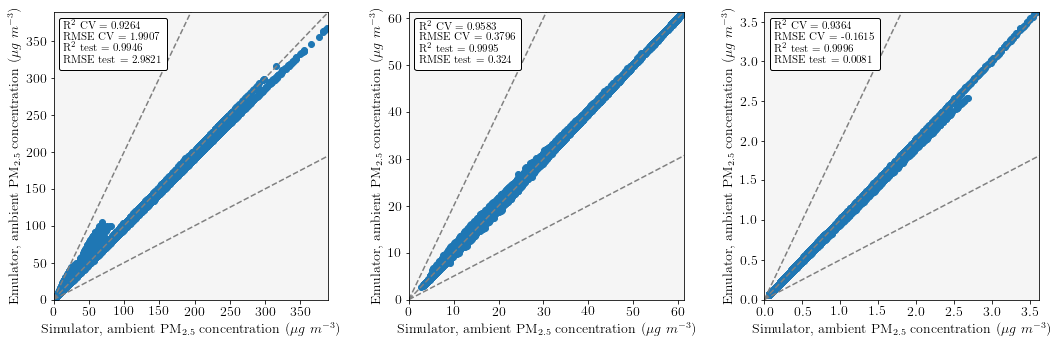

In [182]:
fig = plt.figure(1, figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

outputs = ['PM2_5_DRY', 'o3', 'AOD550_sfc']

for index, output in enumerate(outputs):
    pattern = r'([+-]?\d+.?\d+)'
    
    rmse_cv = pd.to_numeric(df_eval.loc[df_eval.output == output]['rmse_cv'].astype(str).str.extractall(pattern).squeeze(), errors='coerce')
    rmse_cv.loc[rmse_cv > 500] = np.nan # trial and error to see errorneously high values: rmse_cv.value_counts().reset_index().sort_values(by='index')
    rmse_cv = rmse_cv.values.ravel()
    
    r2_cv = pd.to_numeric(df_eval.loc[df_eval.output == output]['r2_cv'].astype(str).str.extractall(pattern).squeeze(), errors='coerce')
    r2_cv.loc[r2_cv > 1.0] = np.nan
    r2_cv = r2_cv.values.ravel()

    y_test = pd.to_numeric(df_eval.loc[df_eval.output == output]['y_test'].astype(str).str.extractall(pattern).squeeze(), errors='coerce').values.ravel()
    y_pred = pd.to_numeric(df_eval.loc[df_eval.output == output]['y_pred'].astype(str).str.extractall(pattern).squeeze(), errors='coerce').values.ravel()

    rmse_test = np.round(np.sqrt(np.abs(mean_squared_error(y_test, y_pred))), decimals=4)
    r2_test = np.round(r2_score(y_test, y_pred), decimals=4)
    pearson_r2_test = pearsonr(y_test, y_pred)[0] ** 2
    
    make_plot(
        index,
        output,
        df_eval_summary,
        'ambient PM$_{2.5}$ concentration (${\mu}g$ $m^{-3}$)',
        y_test,
        y_pred,
        rmse_cv,
        r2_cv,
        rmse_test,
        r2_test
    )

gs.tight_layout(fig, rect=[0, 0, 1.0, 1.0])
plt.show()